## Definitions

In [ ]:
N_FOLDS = '2'
FOLD = '1'

COLAB = True
DAUG_PLUS = True
N_GPUS = 1
CUSTOM_LOSS = False
WEIGHT_CLASS_0 = 1.0
WEIGHT_CLASS_1 = 10.0

# -1 if first run (epoch == 0)
LAST_EPOCH = -1

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 25 11:23:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  
  from os import listdir
  from os.path import isfile, join
  print (listdir(f'/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/train'))

Mounted at /content/drive
['.DS_Store', '0', '1']


## Pytorch

ver detectron p/ depois:
https://blog.roboflow.com/how-to-train-detectron2/

In [ ]:
import torchvision.models as models
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Get normalizations

## Set transformations and load data

In [ ]:
#Transformations (from images to tensor)
transformations = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1), 
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.4961825801749269, 0.24619624513349647)
])

#Data augmentation
transformationsDS1 = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1), 
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.5),
    #transforms.RandomAdjustSharpness(),
    transforms.GaussianBlur(kernel_size=501),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    #transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.4961825801749269, 0.24619624513349647)
])

#Data augmentation
transformationsDS2 = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1), 
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(),
    transforms.RandomAdjustSharpness(sharpness_factor=0.5),
    transforms.GaussianBlur(kernel_size=501),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.4961825801749269, 0.24619624513349647)
])

#Data augmentation
transformationsDS3 = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1), 
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(),
    transforms.RandomAdjustSharpness(sharpness_factor=0.5),
    transforms.GaussianBlur(kernel_size=501),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.4961825801749269, 0.24619624513349647)
])

# Load data COLAB
if COLAB:
  train_set_original = datasets.ImageFolder(f"/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/train", transform = transformations)
  train_set_DA1 = datasets.ImageFolder(f"/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/train", transform = transformationsDS1)
  train_set_DA2 = datasets.ImageFolder(f"/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/train", transform = transformationsDS2)
  train_set_DA3 = datasets.ImageFolder(f"/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_J/{FOLD}/train", transform = transformationsDS3)
  val_set = datasets.ImageFolder(f"/content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test", transform = transformations)

# Load data Jupyter
else:
  train_set_original = datasets.ImageFolder(f"padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/train", transform = transformations)
  train_set_DA1 = datasets.ImageFolder(f"padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/train", transform = transformationsDS1)
  train_set_DA2 = datasets.ImageFolder(f"padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/train", transform = transformationsDS2)
  train_set_DA3 = datasets.ImageFolder(f"padrao_ouro_pr/Stratified_J/{FOLD}/train", transform = transformationsDS3)
  val_set = datasets.ImageFolder(f"padrao_ouro_pr/Stratified_{N_FOLDS}/{FOLD}/test", transform = transformations)

if DAUG_PLUS:
  train_set = torch.utils.data.ConcatDataset([train_set_original,train_set_DA1,train_set_DA2,train_set_DA3])

else:
  train_set = torch.utils.data.ConcatDataset([train_set_original,train_set_DA1,train_set_DA2])

# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =128, shuffle=True)

In [ ]:
train_set

In [ ]:
val_set

Dataset ImageFolder
    Number of datapoints: 2732
    Root location: /content/drive/MyDrive/CNN_Knee/padrao_ouro_pr/Stratified_2/1/test
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=0.4961825801749269, std=0.24619624513349647)
           )

In [ ]:
#O Tensor é uma tupla que contem a img e a label
image, label = train_set_original[0]
type(train_set_original[0])

tuple

In [ ]:
print (train_set_original.class_to_idx)

{'0': 0, '1': 1}


In [ ]:
#Img final tem 3 canais com tam 224x224
image.shape

torch.Size([3, 224, 224])

### Mostrar imagens de cada Dataset de Treino

In [ ]:
#Selecionar fotos aleatoriamente
def get_random_images(num, data_set):
    indices = list(range(len(data_set)))
    np.random.shuffle(indices)
    idx = indices[:num]    
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data_set, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels


#Testar função para imprimir fotos normais
def renormalize(self, tensor):
    minFrom= tensor.min()
    maxFrom= tensor.max()
    minTo = 0
    maxTo=1
    return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))

#### Treino Original

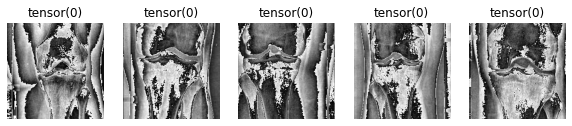

In [ ]:
#for i in range(0, 5):
#    image, label = train_set[i]
#    plt.imshow(transforms.ToPILImage()(image))

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5, train_set_original)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    sub.set_title(str(labels[ii]))
    plt.axis('off')
    plt.imshow(image, cmap='gray_r')
plt.show()

#### Data Augmentation 1

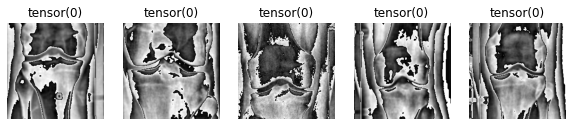

In [ ]:
images, labels = get_random_images(5, train_set_DA1)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    sub.set_title(str(labels[ii]))
    plt.axis('off')
    plt.imshow(image)
plt.show()

#### Data Augmentation 2

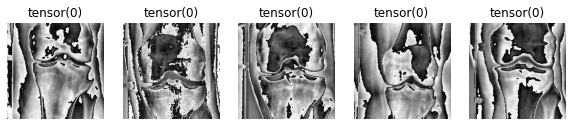

In [ ]:
images, labels = get_random_images(5, train_set_DA2)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    sub.set_title(str(labels[ii]))
    plt.axis('off')
    plt.imshow(image)
plt.show()

#### Data Augmentation 3

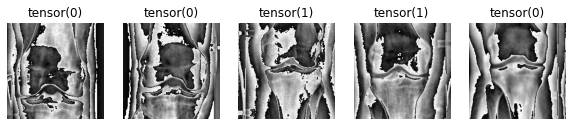

In [ ]:
if DAUG_PLUS:
  images, labels = get_random_images(5, train_set_DA2)
  fig=plt.figure(figsize=(10,10))
  for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    sub.set_title(str(labels[ii]))
    plt.axis('off')
    plt.imshow(image)
  plt.show()

## Load pretrained model (Densenet) and freeze pre-trained layers

In [ ]:
# Get pretrained model using torchvision.models as models library
model = models.densenet161(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

## Re-define the final fully-connected layer

In [ ]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.classifier.in_features
#num_labels = len(train_set.classes)
num_labels = 2
classifier = nn.Sequential(
                           nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           # Ultima camada com ativacao softmax, que tem como saida 
                            # uma probabilidade para cada classe
                           nn.LogSoftmax(dim=1))
# Replace default classifier with new classifier

model.classifier = classifier

## Set GPU

In [ ]:
# Dev Box
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if N_GPUS > 1:
    model= nn.DataParallel(model)
    
# Move model to the device specified above
model.to(device)

cuda


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## Set loss function and optmizer

In [ ]:
# Custom weighted criterion
if CUSTOM_LOSS:
  criterion = nn.NLLLoss(weight=torch.tensor([WEIGHT_CLASS_0, WEIGHT_CLASS_1], device=device))
  print('Using custom weights')

# Standard weighted criterion
else:
  criterion = nn.NLLLoss()
  print('Using standard weights')


# Set the optimizer function using torch.optim as optim library
if N_GPUS > 1:
    optimizer = optim.Adam(model.module.classifier.parameters(),lr= 0.001)

else:
    # Se for somente uma GPU (retirei o .module apos model: aqui, no .train e .eval)
    optimizer = optim.Adam(model.classifier.parameters(),lr= 0.001)

Using standard weights


## Train model

In [ ]:
#Para baixar modelo anterior
if LAST_EPOCH > -1:
  if COLAB:
    model = torch.load(f'/content/drive/MyDrive/CNN_Knee/kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{LAST_EPOCH}_JULIO.pth')

  else:
    model = torch.load(f'kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{LAST_EPOCH}_JULIO.pth')

In [ ]:
torch.cuda.device_count()

1

In [ ]:
epochs = 12
lossestrain = []
lossestest = []

for epoch in range(LAST_EPOCH + 1, epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    if N_GPUS > 1:
        model.module.train()
    else:
        model.train()

    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader))
        
    # Evaluating the model
    if N_GPUS > 1:
        model.module.eval()
    else:
        model.eval()

    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            #y = labels.cpu().numpy()
            #y_pred = np.concatenate(top_class.cpu().numpy())

            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader))
            #print(output)
            #print(labels)
            #roc_auc = roc_auc_score(sigmoid_output_transform)
            #print(roc_auc) 
            
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    lossestrain.append(train_loss)
    lossestest.append(valid_loss)

    if COLAB:
      torch.save(model, f'/content/drive/MyDrive/CNN_Knee/kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{epoch}_JULIO.pth')

    else:
      torch.save(model, f'kneemodel_loss{CUSTOM_LOSS}_{WEIGHT_CLASS_1}_DAug{DAUG_PLUS}_Strat_{N_FOLDS}_f{FOLD}_e{epoch}_JULIO.pth')

    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.\
          format(epoch, train_loss, valid_loss))

1 / 67
2 / 67
3 / 67
4 / 67
5 / 67
6 / 67
7 / 67
8 / 67
9 / 67
10 / 67
11 / 67
12 / 67
13 / 67
14 / 67
15 / 67
16 / 67
17 / 67
18 / 67
19 / 67
20 / 67
21 / 67
22 / 67
23 / 67
24 / 67
25 / 67
26 / 67
27 / 67
28 / 67
29 / 67
30 / 67
31 / 67
32 / 67
33 / 67
34 / 67
35 / 67
36 / 67


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(lossestest)+1), lossestest, color='blue')
plt.plot(range(1,len(lossestest)+1), lossestrain, color='orange')